In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [27]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### load MNIST data

In [28]:
from scipy.io import loadmat
train_mnist = loadmat('mnist_train.mat')

In [29]:
data = train_mnist['train_X']
data.shape

(60000, 784)

In [30]:
labels = train_mnist['train_labels']
labels.shape

(60000, 1)

downsample data to 100000

In [31]:
idx = np.random.randint(60000, size=10000)

In [32]:
data = data[idx, :]

In [33]:
labels = labels[idx]

In [34]:
labels = labels[:,0].tolist()

### regular t-SNE on training data

In [35]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, perplexity=30.0, early_exaggeration=4.0, \
             learning_rate=1000.0, n_iter=1000, n_iter_without_progress=30, \
             min_grad_norm=1e-07, metric='euclidean', init='random', verbose=1, \
             random_state=None, method='barnes_hut', angle=0.5)
data_embeding = model.fit_transform(data) 

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.074788
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.388884
[t-SNE] Error after 325 iterations: 1.388884


In [36]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
print(__version__) # requires version >= 1.9.0
from plotly.graph_objs import *
init_notebook_mode(connected=True)

2.0.8


In [37]:
import colorlover as cl

In [38]:
colors = cl.scales['11']['qual']['Paired']

In [39]:
scatter_color = [colors[x] for x in labels]

In [40]:
points = Scatter(
    x=data_embeding[:,0],
    y=data_embeding[:,1],
    text = labels[:],
    mode='markers',
    marker=dict(
        size = 2,
        color = scatter_color
    )
) 

layout = Layout(
        width=1000,
        height=1000,
        margin=Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        xaxis=dict(
            zeroline=False
        ),
        yaxis=dict(
            zeroline=False
        ),
        scene = dict(
            camera = dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=0.75, y=0.75, z=0.75)
            )
        ),
        legend=dict(orientation="h"),
        showlegend=False
    )


fig = Figure(data=[points], layout=layout)
iplot(fig, show_link=False)

### construct the neural network

In [41]:
D_in, fc1, fc2, fc3, D_out = 784, 500, 500, 2000, 2

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, fc1), torch.nn.ReLU(),
    torch.nn.Linear(fc1, fc2), torch.nn.ReLU(),
    torch.nn.Linear(fc2, fc3), torch.nn.ReLU(),
    torch.nn.Linear(fc3, D_out)
)

### prepare mini-batch data

In [42]:
class MyMNISTDataset(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.x.shape[0]
    

from torch.utils.data import DataLoader


dataset = MyMNISTDataset(data, data_embeding)
data_loader = DataLoader(dataset, batch_size=2000, num_workers=0, shuffle=False)

### train the network

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = torch.nn.MSELoss(size_average=True)

for epoch in range(100):  
    for i, batch in enumerate(data_loader):
        x, y = batch
        x_var = autograd.Variable(x.float())
        y_var = autograd.Variable(y.float())
        y_pred = model(x_var)
        loss = loss_fn(y_pred, y_var) 
        print("epoch {}, batch {}, loss {}".format(epoch, i, loss.data[0]))      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

epoch 0, batch 0, loss 18.041549682617188
epoch 0, batch 1, loss 83.12508392333984
epoch 0, batch 2, loss 36.17427444458008
epoch 0, batch 3, loss 18.20591163635254
epoch 0, batch 4, loss 17.847206115722656
epoch 1, batch 0, loss 16.90121078491211
epoch 1, batch 1, loss 14.780193328857422
epoch 1, batch 2, loss 13.595354080200195
epoch 1, batch 3, loss 19.653181076049805
epoch 1, batch 4, loss 11.776701927185059
epoch 2, batch 0, loss 14.626808166503906
epoch 2, batch 1, loss 10.905976295471191
epoch 2, batch 2, loss 11.486959457397461
epoch 2, batch 3, loss 11.286187171936035
epoch 2, batch 4, loss 10.303487777709961
epoch 3, batch 0, loss 8.525184631347656
epoch 3, batch 1, loss 8.002570152282715
epoch 3, batch 2, loss 7.095318794250488
epoch 3, batch 3, loss 6.3636274337768555
epoch 3, batch 4, loss 5.986606121063232
epoch 4, batch 0, loss 5.3269219398498535
epoch 4, batch 1, loss 5.557558059692383
epoch 4, batch 2, loss 4.956986427307129
epoch 4, batch 3, loss 4.631242752075195
epo

### predict the data and visualization

In [44]:
tst_data = train_mnist['train_X']
tst_idx = np.random.randint(60000, size=10000)
tst_data = tst_data[tst_idx, :]

tst_labels = train_mnist['train_labels']
tst_labels = tst_labels[tst_idx, 0].tolist()

tst_x_var = autograd.Variable(torch.Tensor(tst_data))

In [45]:
tst_y_pred = model(tst_x_var)

In [46]:
tst_data_embed = tst_y_pred.data.numpy()

In [47]:
scatter_color = [colors[x] for x in tst_labels]

In [48]:
tst_points = Scatter(
    x=tst_data_embed[:,0],
    y=tst_data_embed[:,1],
    mode='markers',
    marker=dict(
        size = 2,
        color = scatter_color
    )
) 

iplot({
    'data': [tst_points],
    'layout': layout
    },
    show_link=False)

### visulization the network

In [49]:
x_tnsr = torch.Tensor(data)
type(x_tnsr)

torch.FloatTensor

In [50]:
x = autograd.Variable(x_tnsr)
type(x)

torch.autograd.variable.Variable

In [51]:
y_pred = model(x)

In [52]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph

    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function

    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    pass
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

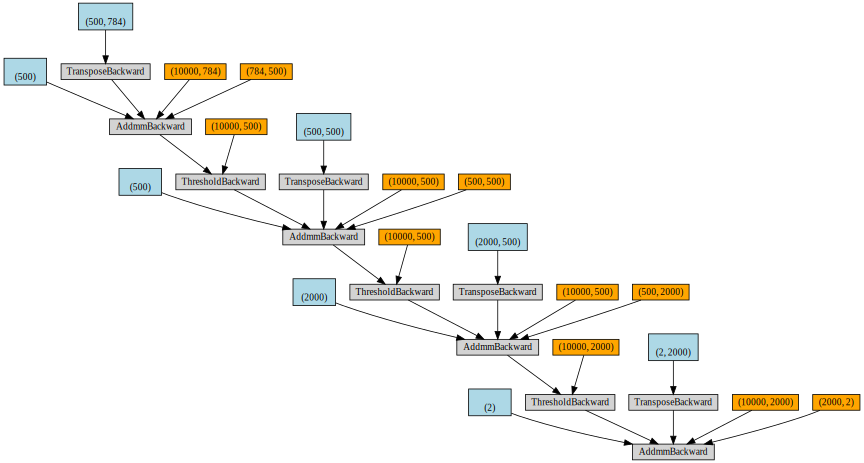

In [53]:
make_dot(y_pred)